# PyTorch Categorical Classifier Example

pip install torch torchvision numpy scipy numpy matplotlib scikit-learn scikit-image jupyterlab

In [1]:
from collections import Counter
import random
import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skimageio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import torch
from torch.utils.data import DataLoader, Dataset

# torchvision is a PyTorch package with pretrained networks etc etc
import torchvision
from torchvision import transforms, models

from PIL import Image 

# Set the main variables

In [2]:
batch_size = 10
nepochs = 5
lr = 1e-4

# Use a subset of the total files
Nfiles = 2000

labels = ['HeadCT', 'Hand']

# ImageNet Transfer Learning Requirments
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

In [3]:
def accuracy(predicted, true):
    return (torch.argmax(predicted, dim=1)==true).float().mean() * 100

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [4]:

#
# GPU CPU - nice way to setup the device as it works on any machine
#
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Device is {device}')

if device == 'cuda':
    print(f'CUDA device {torch.cuda.device(0)}')
    print(f'Number of devices: {torch.cuda.device_count()}')
    print(f'Device name: {torch.cuda.get_device_name(0)}')

Device is cuda
CUDA device <torch.cuda.device object at 0x7f009cadba90>
Number of devices: 2
Device name: TITAN Xp


# Section 1: Data Setup

In the end all data is of the form `channels x slices x rows x columns`

## Create Dataset Class

In [5]:
class MedMNISTDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        """
        Initialized
        """
        super().__init__()
        
        # Store variables we are interested in...
        
        self._filenames = filenames
        self._labels = labels

        # Randomize the filenames as we don't want all the dogs first
        random.shuffle(self._filenames)
        
        self._transforms = transform
        
        
    def __getitem__(self, index):
        """
        Get a single image / label pair.
        """
        
        #
        # Read in the image
        #
        image = skimageio.imread(self._filenames[index])        

        # It seems some PyTorch transforms are tied to PIL so need
        # to create the PIL from the numpy array
        image = Image.fromarray(image)

        #
        #  Can do further processing here or anything else
        #
        
        # image = clahe(image)
        
        #
        # Do transformations on it (typicalyl data augmentation)
        #
        if self._transforms is not None:
            image = self._transforms(image)
        
        #
        # Create the label.. 
        #
        label = self._labels.index(str(self._filenames[index].parent.name))
        
        #
        # Return the image label pair
        #
        return image, label # and anything else you want
    
    @property
    def labels(self):
        return [str(x.parent.name) for x in self._filenames]


    def __len__(self):
        """
        Return length of the dataset
        """
        return len(self._filenames)
        

# Set the Files

In [6]:
path = Path("data")

# Create a list of filenames from the directories in "labels"
filenames = []
for label in labels:
    filenames += list(path.glob(f'{label}/*jpeg'))

random.shuffle(filenames)

#
# If we are going to choose a subset, do it here.
#
if Nfiles is not None:
    filenames = filenames[:Nfiles]

tt, filenames_test = train_test_split(filenames, test_size=0.2)
filenames_train, filenames_validation = train_test_split(tt, test_size=0.1)

print(f'There are {len(filenames_train)} training files.')
print(f'There are {len(filenames_validation)} validation files.')
print(f'There are {len(filenames_test)} testing files.')

There are 1440 training files.
There are 160 validation files.
There are 400 testing files.


## Training Dataset and DataLoader

Artifically create a class imbalance with fewer dog images... BUT, it will probably still be reasonably accurate in the end as the neural network is trained on ImageNet data which includes dogs and cats.

In [7]:
#
#  Training dataset
#

# Data Augmentation!
train_transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.Resize(224),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomAffine(degrees=5, scale=(0.9, 1.1), translate=(0.05, 0.05)),
    
                                # converts 0-255 to 0-1 and rowxcolxchan to chanxrowxcol
                                transforms.ToTensor(),

                                transforms.Normalize(mean=data_mean,
                                                     std=data_std)])

# Create the training dataset
train_dataset = MedMNISTDataset(filenames_train, labels, transform=train_transform)

# #
# # Create a Weighted Sampler -- I beleive this is all correct. 
# #

# class_counts = [len(path_training_cat), len(path_training_dog)]
# print('Class Counts/Imbalance', class_counts)

# # Total samples
# num_samples = sum(class_counts)

# # Get all the labels
# labels = train_dataset.labels #corresponding labels of samples

# # Class imbalance, want to weight more toward the one that has *fewer*
# class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]

# # Create a list that has a weight value for every image/label in the dataset
# weights = [class_weights[labels[i]] for i in range(int(num_samples))]

# # Create the sampler
# weighted_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

#
# Create the training dataloader
#
# train_dataloader = DataLoader(train_dataset, sampler=weighted_sampler, batch_size=batch_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

## Validation Dataset and DataLoader

In [8]:
#
#  Validation dataset
#
validation_transform = transforms.Compose([
                    transforms.Grayscale(num_output_channels=3),

                    transforms.Resize(224),

                    # converts 0-255 to 0-1 and rowxcolxchan to chanxrowxcol
                    transforms.ToTensor(),

                    transforms.Normalize(mean=data_mean,
                                         std=data_std)])

# Create the validation dataset
validation_dataset = MedMNISTDataset(filenames_validation, labels, transform=validation_transform)

# Create the validation dataloader
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

In [9]:
print("train data set:", len(train_dataset))
print("val data set:", len(validation_dataset))

train data set: 1440
val data set: 160


# Show Training and Validation Distribution

Text(0.5, 1.0, 'Test Data')

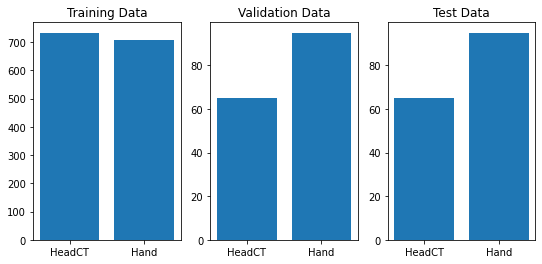

In [10]:
train_labels = Counter(train_dataset.labels)
validation_labels = Counter(validation_dataset.labels)

plt.figure(figsize=[9,4])

plt.subplot(1,3,1)
plt.bar(labels, [train_labels[x] for x in labels])
plt.title('Training Data')

plt.subplot(1,3,2)
plt.bar(labels, [validation_labels[x] for x in labels])
plt.title('Validation Data')

plt.subplot(1,3,3)
plt.bar(labels, [validation_labels[x] for x in labels])
plt.title('Test Data')

# Show Example Images

Note, randomly flipped rotated etc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


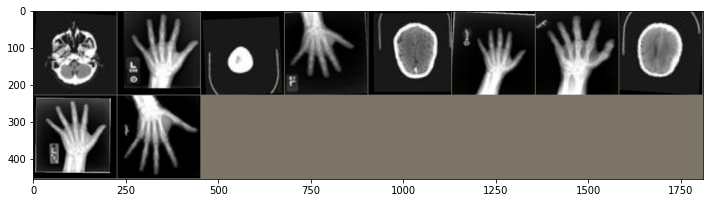

In [11]:
#
#  Example image
#
X_train,y_train = next(iter(train_dataloader))
img = torchvision.utils.make_grid(X_train)

# Put channels last
img = img.numpy().transpose((1,2,0))

# "denormalize" the data
img = img*data_std + data_mean

plt.figure(figsize=[12,5])
plt.imshow(img)

# Section 2: Model Creation

In [12]:
#
#  Create the model
#
#  https://pytorch.org/docs/stable/torchvision/models.html
#

# Load the VGG pretrained model from torchvision
model = models.vgg16(pretrained=True)

#
# Create the classifier part to add to the end of it.
# An alternative methodis `torch.no_grad()`
# https://stackoverflow.com/questions/51748138/pytorch-how-to-set-requires-grad-false
#    Note: "classifier" may not be the correct ending, it depends on the model.
#
model.classifier[6] = torch.nn.Linear(4096, 2)


model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Section 3: Cost and Optimizer

In [13]:
#
#  Create the Loss Function
#
cost = torch.nn.CrossEntropyLoss()

#
#  Create the optimizer
#
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Section 4: Training Loop

In [14]:
#
#  Run through epochs
#


training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

for epoch in range(nepochs):

    since = time.time()
    print("-"*10)
    print(f'Epoch {epoch}/{nepochs}')

    running_loss = 0.0
    running_correct = 0

    # Put the model into "training" mode (pertains to batch normalization etc etc)
    model.train()

    #
    #  Run batches
    #
    param = "train"
    for batchi, data in enumerate(train_dataloader):
        
        # (**) Grab thedata and send to device
        X,y = data

        X = X.to(device)
        y = y.to(device)
                
        # (**) Important!
        optimizer.zero_grad()

        # Run through the data through the model 
        y_pred = model(X)
        
        # Used for accuracy quantification
        _,pred = torch.max(y_pred.data, 1)
        
        # (**) Calcualte the loss
        loss = cost(y_pred,y)

        # (**) Update gradients.
        loss.backward()
        optimizer.step()

        # Compute batch loss and accuracy
        # loss.item() is the average loss over the batch
        running_loss += loss.item() * X.shape[0]
        
        running_correct += torch.sum(pred == y.data)
        
        if batchi%5 == 4 and param == "train":
            print("\tBatch {}, Train Loss:{:.4f}, Train Accuracy:{:.4f}".format(
                    batchi, 
                    running_loss/(batch_size*(batchi+1)), 
                    100*running_correct/(batch_size*(batchi+1))))
                                            

    # 
    # Run Validation data
    #
    param = "val"
    
    # Put the model into evaluation mode (to do with batch normalization, dropout etc)
    model.eval()
    
    # Don't update gradients
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for batchi, data in enumerate(validation_dataloader):
            
            # Grab thedata and send to device
            X,y = data

            X = X.to(device)
            y = y.to(device)
            
            # Run through the model 
            y_pred = model(X)
            _,pred = torch.max(y_pred.data, 1)
            
            # Calcualte the loss
            loss = cost(y_pred, y)

            # loss.item() is the average loss over the batch
            val_loss += loss.item() * batch_size
            
            val_correct += torch.sum(pred == y.data)
            
    # Epoch loss
    training_loss.append(running_loss/len(train_dataset))
    training_accuracy.append(100*running_correct/len(train_dataset))
    print("Training Loss:{:.4f}, Accuracy:{:.1f}".format(training_loss[-1], training_accuracy[-1]))

    # Validation loss
    validation_loss.append(val_loss/len(validation_dataset))
    validation_accuracy.append(100*val_correct/len(validation_dataset))

    print("Validation Loss:{:.4f}, Accuracy:{:.1f}".format(
        val_loss/len(validation_dataset), 100*val_correct/len(validation_dataset)))

now_time = time.time() - since
print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

----------
Epoch 0/5
	Batch 4, Train Loss:0.4197, Train Accuracy:80.0000
	Batch 9, Train Loss:0.2133, Train Accuracy:90.0000
	Batch 14, Train Loss:0.1422, Train Accuracy:93.3333
	Batch 19, Train Loss:0.1066, Train Accuracy:95.0000
	Batch 24, Train Loss:0.0853, Train Accuracy:96.0000
	Batch 29, Train Loss:0.0711, Train Accuracy:96.6667
	Batch 34, Train Loss:0.0609, Train Accuracy:97.1429
	Batch 39, Train Loss:0.0533, Train Accuracy:97.5000
	Batch 44, Train Loss:0.0474, Train Accuracy:97.7778
	Batch 49, Train Loss:0.0427, Train Accuracy:98.0000
	Batch 54, Train Loss:0.0388, Train Accuracy:98.1818
	Batch 59, Train Loss:0.0428, Train Accuracy:98.1667
	Batch 64, Train Loss:0.1929, Train Accuracy:97.0769
	Batch 69, Train Loss:0.1791, Train Accuracy:97.2857
	Batch 74, Train Loss:0.1863, Train Accuracy:97.0667
	Batch 79, Train Loss:0.1746, Train Accuracy:97.2500
	Batch 84, Train Loss:0.1644, Train Accuracy:97.4118
	Batch 89, Train Loss:0.1600, Train Accuracy:97.4445
	Batch 94, Train Loss:0.151

# Statistics and Information

## Loss and Accuracy Curves

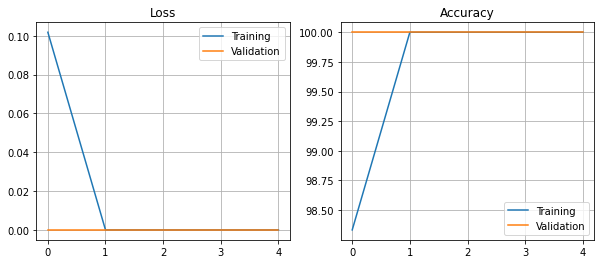

In [15]:
plt.figure(figsize=[10,4])

# Loss
plt.subplot(1,2,1)
plt.plot(training_loss)
plt.plot(validation_loss)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.grid('on')

# Accuracy
plt.subplot(1,2,2)
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.grid('on')

# Section 5: Testing

In [16]:
#
#  Test dataset
#

# Create the validation dataset
test_dataset = MedMNISTDataset(filenames_test, labels, transform=validation_transform)

# Create the validation dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)



Classification Report
              precision    recall  f1-score   support

      HeadCT       1.00      1.00      1.00       188
        Hand       1.00      1.00      1.00       212

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



Confusion Matrix


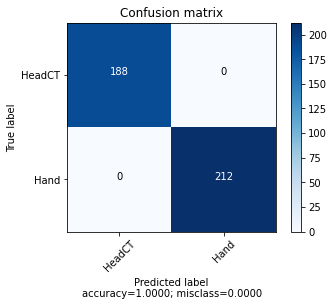

In [17]:
y_label_all = []
y_pred_all = []
pred_all = []

with torch.no_grad():
    
    # Put the model in evaluation (batch normalization and dropout stuff)
    model.eval()

    # Get the next test dataset
    for image, label in test_dataloader:
    
        # Send to the device and call the model
        image = image.to(device)
        label = label.to(device)
        
        y_pred = model(image)
        _,pred = torch.max(y_pred.data, 1)

        y_label_all.append(label.cpu().detach().numpy())
        y_pred_all.append(y_pred.cpu().detach().numpy()[:,1])
        pred_all.append(pred.cpu().detach().numpy())

        # Compute loss and stats
        test_correct = torch.sum(pred == label.data)

    y_label_all = np.array(y_label_all).ravel()
    y_pred_all = np.array(y_pred_all).ravel()
    pred_all = np.array(pred_all).ravel()

    # Classification Report
    print('\n\nClassification Report')
    print(classification_report(pred_all, y_label_all, target_names=labels))
    
    # Confusion Matrix
    print('\n\nConfusion Matrix')
    cm = confusion_matrix(pred_all, y_label_all)
    plot_confusion_matrix(cm, labels, normalize=False)


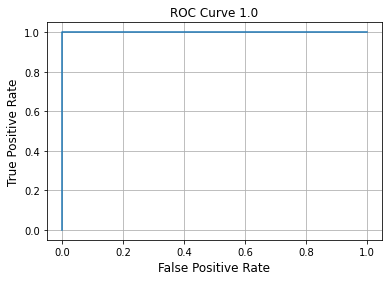

In [18]:
fpr, tpr, thresholds = roc_curve(y_label_all, y_pred_all)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve {roc_auc_score(y_label_all, y_pred_all):0.3}')
plt.grid('on')